In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
path = '/content/gdrive/My Drive/ECE763/'
import numpy as np
import cv2
from scipy.stats import multivariate_normal
from scipy.special import psi, gammaln
from scipy.optimize import fminbound
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import random
np.random.seed(2)
facetrain= np.load(path+'MyData4/ftrain.npy')
nonfacetrain= np.load(path+'MyData4/nftrain.npy')
facetest= np.load(path+'MyData4/ftest.npy')
nonfacetest= np.load(path+'MyData4/nftest.npy')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def fit_fa(X,K,iterations):
  I = X.shape[0]
  D = X.shape[1]
  mu = np.sum(X,axis=0)/I
  phi = np.random.rand(D,K)

  x_minus_mu = np.subtract(X, mu)
  sig = np.sum (np.square(x_minus_mu), axis=0) / I


  iterations_count = 0
  while iterations_count != iterations:
    if iterations_count != 0 :
      inv_sig = np.diag(1/np.reshape(sig,D)) 
    else:
      inv_sig = np.diag(1 / sig)
    phi_transpose_times_sig_inv = np.matmul(np.transpose(phi), inv_sig)
    temp = np.linalg.inv(np.matmul(phi_transpose_times_sig_inv,phi) + np.eye(K))
    E_hi = np.matmul(np.matmul(temp,phi_transpose_times_sig_inv), np.transpose(x_minus_mu))
    E_hi_hitr = []
    for i in range(I):
      e = np.transpose(np.array([E_hi[:,i]]))
      E_hi_hitr.append(temp + np.matmul(e,np.transpose(e)))
    E_hi_hitr = np.array([E_hi_hitr])

    phi_1 = np.zeros((D,K))
    for i in range(I):
      phi_1 = phi_1 + np.matmul(np.transpose(np.array([x_minus_mu[i,:]])),np.array([E_hi[:,i]]))
    phi_2 = np.zeros((K,K))
    for i in range(I):
      phi_2 = phi_2 + E_hi_hitr[0][i]
    phi_2 = np.linalg.inv(phi_2)
    phi = np.matmul(phi_1 , phi_2)

    sig_diag = np.zeros([D,1])
    for i in range(I):
      xm = np.transpose(np.array([x_minus_mu[i,:]]))
      sig_1 = np.multiply(xm,xm)
      sig_2 = np.multiply(np.matmul(phi,np.transpose(np.array([E_hi[:,i]]))), xm)
      sig_diag = sig_diag + sig_1 - sig_2
    sig = sig_diag/I

    iterations_count = iterations_count + 1;       
    print('Iteration number: ',iterations_count)
  return mu,phi,sig

Iteration number:  1
Iteration number:  2
Iteration number:  3
Iteration number:  4
Iteration number:  5
Iteration number:  6
Iteration number:  7
Iteration number:  8
Iteration number:  9
Iteration number:  10


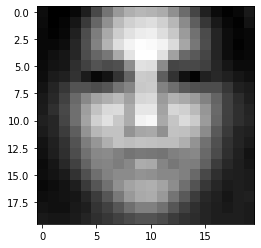

In [5]:
dimm = 20
Xf = facetrain
K = 2
iterations = 10
af,bf,cf = fit_fa(Xf,K,iterations)

mean = 255*af / max(af)
mu_mat = np.reshape(mean,(dimm,dimm,3))
mu_mat1 = cv2.cvtColor(mu_mat.astype('uint8'), cv2.COLOR_BGR2RGB)
import matplotlib.pyplot as plt
grayImage = cv2.cvtColor(mu_mat1.astype('uint8'), cv2.COLOR_RGB2GRAY)
plt.imshow(grayImage,cmap="gray")

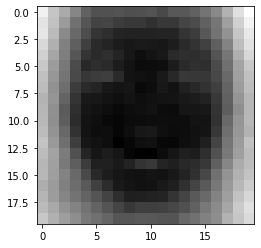

In [6]:
sig = 255*cf / np.max(cf)
mu_sig = np.reshape(sig,(dimm,dimm,3))
mu_sig1 = cv2.cvtColor(mu_sig.astype('uint8'), cv2.COLOR_BGR2RGB)

import matplotlib.pyplot as plt
grayImagesig = cv2.cvtColor(mu_sig1.astype('uint8'), cv2.COLOR_RGB2GRAY)
plt.imshow(grayImagesig,cmap="gray")

Iteration number:  1
Iteration number:  2
Iteration number:  3
Iteration number:  4
Iteration number:  5
Iteration number:  6
Iteration number:  7
Iteration number:  8
Iteration number:  9
Iteration number:  10


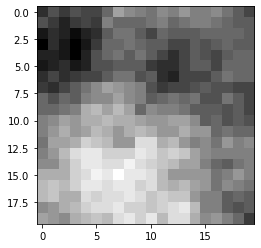

In [7]:
Xnf = nonfacetrain
anf,bnf,cnf = fit_fa(Xnf,K,iterations)
mean = 255*anf / max(anf)
mu_mat = np.reshape(mean,(dimm,dimm,3))
mu_mat1 = cv2.cvtColor(mu_mat.astype('uint8'), cv2.COLOR_BGR2RGB)
import matplotlib.pyplot as plt
grayImage = cv2.cvtColor(mu_mat1.astype('uint8'), cv2.COLOR_RGB2GRAY)
plt.imshow(grayImage,cmap="gray")



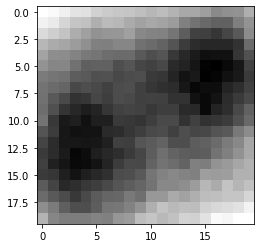

In [8]:
sig = 255*cnf / np.max(cnf)
mu_sig = np.reshape(sig,(20,20,3))
mu_sig1 = cv2.cvtColor(mu_sig.astype('uint8'), cv2.COLOR_BGR2RGB)

import matplotlib.pyplot as plt
grayImagesig = cv2.cvtColor(mu_sig1.astype('uint8'), cv2.COLOR_RGB2GRAY)
plt.imshow(grayImagesig,cmap="gray")

In [0]:
var_face = np.dot(bf,np.transpose(bf)) + np.diag(cf)
var_face_nf = np.dot(bnf,np.transpose(bnf)) + np.diag(cnf)

In [0]:
Xf_test = facetest
Xnf_test = nonfacetest
I,D = Xf.shape


In [0]:
def prob():
  px_face_pf = multivariate_normal.pdf(Xf_test, af.reshape((D,)), cov=var_face,allow_singular=True)
  px_face_pnf = multivariate_normal.pdf(Xf_test, anf.reshape((D,)), cov=var_face_nf,allow_singular=True)
  total = px_face_pf + px_face_pnf
  Prob_face = px_face_pf / total

  px_nonface_pf = multivariate_normal.pdf(Xnf_test, af.reshape((D,)), cov=var_face,allow_singular=True)
  px_nonface_pnf = multivariate_normal.pdf(Xnf_test, anf.reshape((D,)), cov=var_face_nf,allow_singular=True)
  total = px_nonface_pf + px_nonface_pnf
  Prob_nonface = px_nonface_pnf/ total
  return Prob_face,Prob_nonface



In [12]:
P_face,P_nonface = prob()
True_positive = np.sum(P_face[:] >= 0.5)
False_negative = 100 - True_positive 
True_negative = np.sum(P_nonface[:] >= 0.5)
False_positive = 100 - True_negative

fpr =  False_positive/ (False_positive + True_negative)
fnr =  False_negative / (False_negative + True_positive)
miss = ( False_positive+ False_negative) / 200

print('False Positive Rate:',fpr)
print('False Negative Rate:',fnr)
print('Miss Classification Rate:', miss)

False Positive Rate: 0.46
False Negative Rate: 0.24
Miss Classification Rate: 0.35


In [0]:
labels = np.array([np.ones(100),np.zeros(100)])
labels = np.reshape(labels,(200))
X_test_roc = np.array([facetest,nonfacetest])
X_test_roc = np.reshape(X_test_roc,(200,1200))

In [0]:
row,col = X_test_roc.shape
prob_fpf_Roc = multivariate_normal.pdf(X_test_roc, af.reshape((col,)), cov=var_face,allow_singular=True)
prob_fnpf_Roc = multivariate_normal.pdf(X_test_roc, anf.reshape((col,)), cov=var_face_nf,allow_singular=True)
total_Roc = prob_fpf_Roc + prob_fnpf_Roc
P_Roc = prob_fpf_Roc / total_Roc


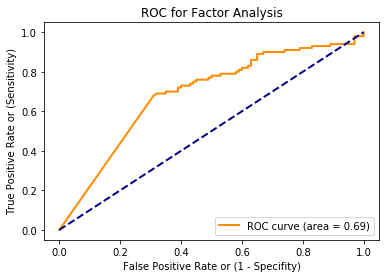

In [15]:
fpr, tpr, thresholds = metrics.roc_curve(labels,P_Roc)
roc_auc = roc_auc_score(labels,P_Roc)
# Plot ROC curve
plt.plot(fpr, tpr,color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  

plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('ROC for Factor Analysis')
plt.legend(loc="lower right")